In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Jaynes-Cummings Hamiltonian

$$
\hat{H} = \hbar\omega_\text{c}\hat{a}^\dagger\hat{a} 
+ \hbar\omega_a\hat{\sigma}^\dagger\hat{\sigma} 
+ \hbar g\left(
\hat\sigma^\dagger\otimes\hat{a}
+\hat\sigma\otimes\hat{a}^\dagger
\right) + \frac{\hbar\Omega}{2}\left(
\hat{a}e^{-\mathrm{i}\omega_\text{L}t}
+\hat{a}^\dagger e^{\mathrm{i}\omega_\text{L}t}
\right)
$$
where $\omega_\text{c}$ is the cavity's resonance frequency, $\omega_\text{a}$ is the atomic resonance frequency, $g$ is the coupling coefficient and $\Omega$ the drive strength. Applying the correct unitary (it's probably $\hat{U}=e^{\mathrm{i}\omega_\text{L}(\hat{a}^\dagger \hat{a}+\hat{\sigma}^\dagger\hat{\sigma})t}$) will put our Hamiltonian in the frame co-rotating with the laser and remove explicit time dependence. It should end up being
$$
\hat{H} = \hbar\Delta_\text{c}\hat{a}^\dagger\hat{a} 
+ \hbar\Delta_\text{a}\hat{\sigma}^\dagger\hat{\sigma} 
+ \hbar g\left(
\hat\sigma^\dagger\otimes\hat{a}
+\hat\sigma\otimes\hat{a}^\dagger
\right) + \frac{\hbar\Omega}{2}\left(
\hat{a}+\hat{a}^\dagger
\right)
$$
In the notes from Vuckovic's group they set $\Delta_a\to\Delta_c+\delta$, which makes sense; that way $\Delta_c$ just describes tuning the laser drive.

First we need to specify the operators. Because $\hat{a}$ and $\hat{\sigma}$ operate on different Hilbert spaces, our operators are tensor products, i.e., $\hat{a}\to\hat{I}\otimes\hat{a}$ and $\hat{\sigma}\to\hat{\sigma}\otimes\hat{I}$.

In [2]:
nphotons = 15
a = qp.tensor(qp.qeye(2), qp.destroy(nphotons))
sm = qp.tensor(qp.destroy(2), qp.qeye(nphotons))

We also need to define our collapse operators. In the Vuckovic paper they assume the "good emitter" limit, i.e. $\kappa\gg\gamma$. Here I just give $\gamma=\kappa/10$.

In [3]:
kappa = 1 # everything is referenced to this freq., but just to make that explicit.
gamma = kappa/10
c_op = [np.sqrt(kappa)*a, np.sqrt(gamma)*sm]

Then we define some parameters for our Hamiltonian. It's maybe interesting to sweep the laser detuning, so I leave that free via a `lambda` function.

In [4]:
g = 0.6 * kappa
delta = 3 * g
Omega = 0.4*np.sqrt(kappa/2 + 2*np.imag(np.sqrt(g**2-(kappa/4+1j*delta/2)**2)))
def jchamiltonian(det): 
    return (det*a.dag()*a               # cavity energy 
            + (det+delta)*sm.dag()*sm   # atom energy
            + g*(sm.dag()*a+sm*a.dag()) # coupling
            + 0.5*Omega*(a+a.dag()))    # drive

QuTiP allows us to calculate the steady-state Hamiltonian:

In [5]:
def rho_ss_atom(det): 
    return qp.steadystate(jchamiltonian(det), c_op)

and thence expectation values, like

Text(0.5,1,'total hamiltonian')

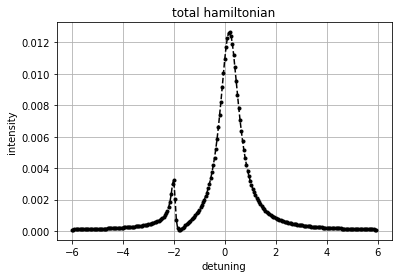

In [6]:
detunings = np.arange(-6, 6, 0.05)
def intensity(det): 
    return qp.expect(a.dag()*a, rho_ss_atom(det))

intensities = np.vectorize(intensity)(detunings)

plt.plot(detunings, intensities, "k.--")
plt.grid()
plt.xlabel("detuning")
plt.ylabel("intensity")
plt.title("total hamiltonian")

In their notebook the authors solve the atomless Hamiltonian with identical drive to determine the correct coherent state to add:

Text(0.5,1,'bare cavity')

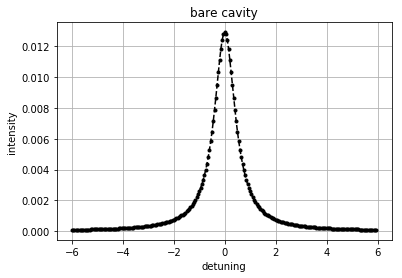

In [11]:
def barehamiltonian(det): 
    return (det*a.dag()*a               # cavity energy 
            + 0.5*Omega*(a+a.dag()))    # drive

def rho_ss_bare(det): 
    return qp.steadystate(barehamiltonian(det), c_op)

def intensity(det): 
    return qp.expect(a.dag()*a, rho_ss_bare(det))

detunings = np.arange(-6, 6, 0.05)
intensities = np.vectorize(intensity)(detunings)

plt.plot(detunings, intensities, "k.--")
plt.grid()
plt.xlabel("detuning")
plt.ylabel("intensity")
plt.title("bare cavity")

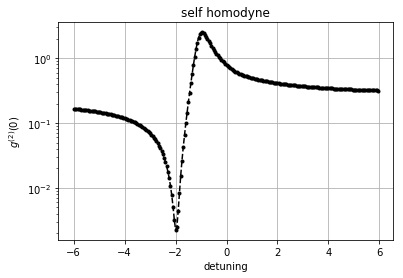

In [12]:
alphas = np.vectorize(lambda det: -qp.expect(rho_ss_bare(det), a))(detunings)
g20v = []
for det, alpha in zip(detunings, alphas):
    b = a + alpha
    g20 = (qp.expect(rho_ss_atom(det), b.dag()*b.dag()*b*b)
           /qp.expect(rho_ss_atom(det), b.dag()*b)**2)
    g20v.append(g20)
    
plt.plot(detunings, g20v, "k.--")
plt.grid()
plt.xlabel("detuning")
plt.ylabel("$g^{(2)}(0)$")
plt.title("self homodyne")
plt.yscale("log")

We can also calculate the time dynamics for this case at optimal detuning (-2). There is a built-in function for QuTiP, but we'll follow what they do in their notes and manually do the quantum regression.

In [13]:
def b(det): 
    return a - qp.expect(rho_ss_bare(det), a)

def numerator(det, dm): 
    return qp.expect(b(det).dag()*b(det), dm)

def denominator(det): 
    return qp.expect(b(det).dag()*b(det), rho_ss_atom(det))**2

def densitymatrix(det, rho0, taulist):
    return qp.mesolve(jchamiltonian(det),            # the hamiltonian
                      b(det)*rho0(det)*b(det).dag(), # the "state"
                      taulist,                       # delays at which to evaluate
                      c_op,                          # collapse operators
                      [],                            # list of ops. to calculate expt. vals. (empty)
                      options=qp.Options(atol=1e-13, # options for ODE solver
                                         rtol=1e-11, 
                                         order=12,
                                         tidy=False))

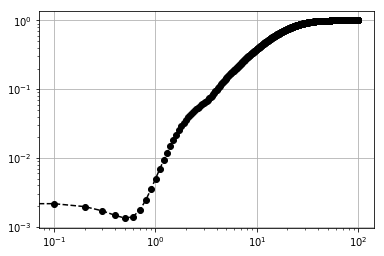

In [14]:
taulist = np.linspace(0, 100, 1000)
sol = densitymatrix(-2, rho_ss_atom, taulist)
g2w = np.vectorize(lambda s: numerator(-2, s)/denominator(-2))(sol.states)

plt.plot(taulist, g2w, "ko--")
plt.grid()
plt.yscale("log")
plt.xscale("log")

So there's maybe some numerical goofiness at the $10^{-3}$ level, but otherwise this behaves the way you believe it should.

# Kerr Hamiltonian
We can define a Kerr Hamiltonian similar to the one above
$$
\hbar^{-1}\hat{H} = \Delta\hat{a}^\dagger\hat{a} 
+ U\hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a}
+ \frac{1}{2}\Omega\left(
\hat{a}^\dagger + \hat{a}
\right)
$$

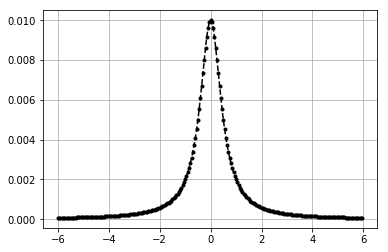

In [15]:
kappa = 1
Omg = 0.1
u = 0.001
a = qp.destroy(nphotons)
c_op = [np.sqrt(kappa)*a]

def kerrh(det):
    return (det*a.dag()*a
            + u*a.dag()*a.dag()*a*a
            + Omg/2*(a.dag() + a))

def rho_ss(det, ham):
    return qp.steadystate(ham(det), c_op)

def intensity(det, rhof):
    return qp.expect(a.dag()*a, rhof(det))

plt.plot(detunings, np.vectorize(intensity)(detunings, 
                                            lambda det: rho_ss(det, kerrh)), 
         "k.--")
plt.grid()

Does the same logic work as above? We can calculate the bare-cavity response to get a list of coherent states.

(-1, 1)

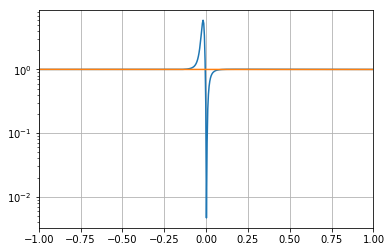

In [16]:
def berrh(det):           # get it?
    return (det*a.dag()*a
            + Omg/2*(a.dag() + a))

def b(det, alpha): 
    return a + 1j*alpha

def c(det, alpha): 
    return a # to compare with 

def g2at0(det, ham, op, alpha):
    rho0 = rho_ss(det, ham)
    numerator = qp.expect(op(det, alpha).dag()*op(det, alpha).dag()*op(det, alpha)*op(det, alpha), rho0)
    denominator = qp.expect(op(det, alpha).dag()*op(det, alpha), rho0)**2
    return numerator.real/denominator.real

# determine optimal coherent state
from scipy.optimize import minimize
ans = minimize(lambda x: g2at0(x[0], kerrh, b, x[1]+1j*x[2]), (0, 1.0, 0), method="Nelder-Mead")
alphaopt = ans.x[1] + 1j*ans.x[2]

# plot
detunings = np.linspace(-1, 1, 500)
plt.plot(detunings, np.vectorize(lambda d: g2at0(d, kerrh, b, alphaopt))(detunings))
plt.plot(detunings, np.vectorize(lambda d: g2at0(d, kerrh, c, alphaopt))(detunings))
plt.yscale("log")
plt.grid()
plt.xlim(-1, 1)

Now let's see if we can do quantum regression

In [17]:
def b(det): 
    return a + 1j*alphaopt

def numerator(det, dm): 
    return qp.expect(b(det).dag()*b(det), dm)

def denominator(det): 
    return qp.expect(b(det).dag()*b(det), rho_ss(det, kerrh))**2

def densitymatrix(det, taulist):
    return qp.mesolve(kerrh(det),                             # the hamiltonian
                      b(det)*rho_ss(det, kerrh)*b(det).dag(), # the "state"
                      taulist,                                # delays at which to evaluate
                      c_op,                                   # collapse operators
                      [],                                     # 
                      options=qp.Options(atol=1e-13,          # options for ODE solver
                                         rtol=1e-11, 
                                         order=12,
                                         tidy=False))

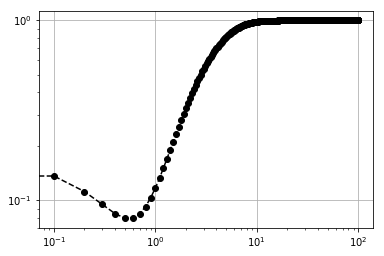

In [21]:
det = -0.001
taulist = np.linspace(0, 100, 1000)
sol = densitymatrix(det, taulist)
g2w = np.vectorize(lambda s: numerator(det, s)/denominator(det))(sol.states)

plt.plot(taulist, g2w, "ko--")
plt.grid()
plt.yscale("log")
plt.xscale("log")